# Random Forest Regessor Model

## Package imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

## Download Data

In [2]:
aapl_data = yf.download("AAPL", start="2018-01-01", end="2020-12-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.188164,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.180992,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.372269,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.843311,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.687893,82271200
...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.157608,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.161407,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852493,124486200


## Plot the Adjusted Closing Price

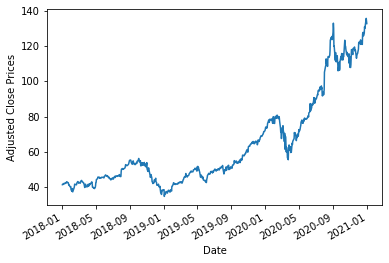

In [4]:
aapl_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

## % Change Histogram

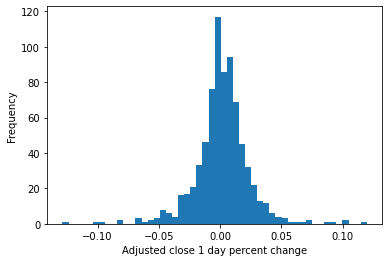

In [5]:
aapl_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

## Feature engineering with MA and RSI

In [6]:
feature_names = []
for n in [14, 30, 50, 200]:
    aapl_data[str(n) + 'd' + ' ma'] = SMAIndicator(aapl_data['Adj Close'], window=n).sma_indicator()
    aapl_data[str(n) + 'd' + ' rsi'] = RSIIndicator(aapl_data['Adj Close'], window=n).rsi()

    feature_names = feature_names + [str(n) + 'd' + ' ma' , str(n) + 'd' + ' rsi']

In [7]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,30d ma,30d rsi,50d ma,50d rsi,200d ma,200d rsi
Date,,,,,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.188164,102223600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.180992,118071600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.372269,89738400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.843311,94640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.687893,82271200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.157608,88223700,125.065425,66.473405,121.345264,60.588092,118.721912,58.623996,97.959236,57.312137
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.161407,54930100,125.755456,67.920988,121.758715,61.315727,118.940340,59.063581,98.308572,57.454610
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852493,124486200,126.674078,73.647465,122.337812,64.485589,119.262114,61.037550,98.644645,58.111252


In [8]:
aapl_data['1d_vol_change'] = aapl_data['Volume'].pct_change()

volume_features = ['1d_vol_change']
feature_names.extend(volume_features)

In [9]:
aapl_data['5d_future_close'] = aapl_data['Adj Close'].shift(-5)
aapl_data['5d_close_future_pct'] = aapl_data['5d_future_close'].pct_change(5)

In [10]:
aapl_data.head(25)

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,30d ma,30d rsi,50d ma,50d rsi,200d ma,200d rsi,1d_vol_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.188164,102223600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.683113,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.180992,118071600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155033,41.673542,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.372269,89738400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.239966,41.910259,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.843311,94640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054621,42.343037,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.687893,82271200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.130693,42.127846,NaN
2018-01-09,43.637501,43.764999,43.352501,43.582500,41.683113,86336000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049407,42.823647,0.027362
2018-01-10,43.290001,43.575001,43.250000,43.572498,41.673542,95839600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110077,42.861889,0.028516
2018-01-11,43.647499,43.872501,43.622501,43.820000,41.910259,74670800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.220877,42.670612,0.018142
2018-01-12,44.044998,44.340000,43.912498,44.272499,42.343037,101672400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361609,42.321526,-0.000508


## Drop NaN

In [11]:
aapl_data.dropna(inplace=True)
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,30d ma,30d rsi,50d ma,50d rsi,200d ma,200d rsi,1d_vol_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2018-10-16,54.732498,55.747501,54.189999,55.537498,53.727081,116736000,54.151190,50.940183,53.811736,54.276208,53.120971,56.148581,45.643911,56.906095,-0.052191,53.867367,0.002611
2018-10-17,55.575001,55.660000,54.834999,55.297501,53.494915,91541600,54.086235,49.875822,53.765946,53.636316,53.192578,55.695395,45.705445,56.701416,-0.215824,52.019623,-0.027578
2018-10-18,54.465000,54.935001,53.250000,54.005001,52.244541,130325200,53.918322,44.484862,53.708869,50.330402,53.238502,53.329891,45.760762,55.618605,0.423672,53.158737,0.017498
2018-10-19,54.514999,55.314999,54.357498,54.827499,53.040234,132314800,53.780986,48.313491,53.692826,52.267173,53.292483,54.582476,45.819102,56.154118,0.015266,52.312260,-0.013725
2018-10-22,54.947498,55.840000,54.735001,55.162498,53.364315,115168400,53.631902,49.831100,53.711529,53.038716,53.355944,55.083498,45.876707,56.369616,-0.129588,51.330353,-0.038115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,127.026901,98208600,122.080259,65.762796,119.295469,59.309267,117.630034,57.731375,96.486344,57.003693,-0.375437,130.157608,0.024646
2020-12-17,128.899994,129.580002,128.039993,128.699997,127.911438,94359800,122.939958,67.110679,119.757552,59.970966,117.904705,58.125450,96.764254,57.130833,-0.039190,131.161407,0.025408
2020-12-18,128.960007,129.100006,126.120003,126.660004,125.883957,192541500,123.480199,61.166486,120.017119,57.744382,118.141008,56.885019,97.036829,56.744297,1.040503,135.852493,0.079188


## Train Test Split

In [12]:
X = aapl_data[feature_names]
y = aapl_data['5d_close_future_pct']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Grid Search CV

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Train the model

In [15]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

## Base Model Best Parameters and Score

In [16]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [24]:
rf_random.best_score_

0.5421028109577739